In [1]:
import random, math
from collections import namedtuple, deque
from itertools import count

import torch
from torch import nn, optim
import torch.nn.functional as F

import gym

import matplotlib.pyplot as plt

In [2]:
lr = 5e-4
batch_size = 32
gamma = 0.98

In [3]:
Transition = namedtuple(
    typename='Transition',
    field_names=('state', 'action', 'reward', 'next_state')
)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, k=batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.relu(self.fc3(x))

    def action(self, state, eps_threshold):
        sample = random.random()
        _action = self.forward(state).argmax().view(1, 1)
        return torch.tensor([[random.randrange(2)]]) if sample < eps_threshold else _action

In [5]:
def train(policy_net, target_net, memory, optimizer):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_action_values = policy_net(state_batch).gather(dim=1, index=action_batch)
    next_state_values = torch.zeros(batch_size)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(dim=1)[0].detach()
    expected_state_action_values = reward_batch + gamma * next_state_values.unsqueeze_(dim=1)
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

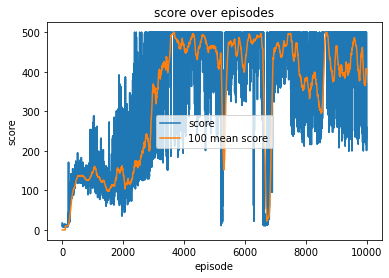

In [6]:
env = gym.make('CartPole-v1')
policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayMemory(10000)

eps_start = 0.1
eps_end = 0.01
update_interval = 20

durations = []
n_episodes = 10000
for epi in range(1, n_episodes + 1):
    eps_threshold = max(eps_end, eps_start - 0.01 * (epi / 200))
    state = torch.tensor([env.reset()]).float()

    for t in count(1):
        action = policy_net.action(state, eps_threshold)
        next_state, reward, done, _ = env.step(action.item())
        next_state = None if done else torch.tensor([next_state]).float()
        reward = torch.Tensor([[reward]])
        memory.push(state, action, reward, next_state)
        state = next_state

        if done:
            durations.append(t)
            break
    for _ in range(10):
        train(policy_net, target_net, memory, optimizer)
    if epi % update_interval == 0:
        target_net.load_state_dict(policy_net.state_dict())
env.close()

plt.plot(durations)
durations_t = torch.tensor(durations, dtype=torch.float)
means = durations_t.unfold(dimension=0, size=100, step=1).mean(dim=1).view(-1)
means = torch.cat((torch.zeros(99), means))

plt.plot(durations, color='#1f77b4', label='score')
plt.plot(means.numpy(), color='#ff7f0e', label='100 mean score')
plt.title('score over episodes')
plt.ylabel('score')
plt.xlabel('episode')
plt.legend(loc='lower right')
plt.show()

[Reference](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)